In [1]:
import requests
import re
import sqlite3

# URL of the webpage to scrape
url = 'https://myneta.info/LokSabha2019/index.php?action=summary&subAction=crime&sort=candidate#summary'

# Send a GET request to the URL and fetch the HTML content
response = requests.get(url)
content = response.content.decode('utf-8')

# Define regular expressions to match the data in the table

#regex = "<table style=.*?>(.*?)</table>"
row_pattern = r'<tr[^>]*>(.*?)<\/tr>'

cell_pattern = "<td.*?>(.*?)</td.*?>"

conn = sqlite3.connect('loksabha_data.db')
cursor = conn.cursor()

# Create a table to store the candidate data
sql_query = 'DROP TABLE IF EXISTS criminal_cases'
cursor.execute(sql_query)

cursor.execute('''
    CREATE TABLE IF NOT EXISTS criminal_cases  (
        Sno VARCHAR,
        Candidate VARCHAR,
        Constituency VARCHAR,
        Party VARCHAR,
        Criminal_Cases VARCHAR,
        Education VARCHAR,
        Total_Assets VARCHAR,
        Liabilities VARCHAR
    )
''')

# Extract rows from the table using regular expressions
rows = re.findall(row_pattern, str(content), re.DOTALL)

# Extract data from each row of the table and insert into the database
for row in rows:
    # Extract data from each cell in the row using regular expressions
    cells = re.findall(cell_pattern, row, re.DOTALL)
    if len(cells) >= 8:
        sno = cells[0].strip()
        candidate = re.compile("<a href=.*?>(.*?)</a><b>").findall(cells[1])[0]
        constituency = cells[2].strip()
        party = cells[3].strip()
        criminal_cases = re.compile("<span style=.*?>(.*?)</span>").findall(cells[4])[0]
        education = cells[5].strip()
        total_assets_str = re.compile(r"Rs&nbsp;([\d,]+)<br>").findall(cells[6])
        total_assets = int(total_assets_str[0].replace(",", "")) if total_assets_str else 0
        liabilities = re.compile("Rs&nbsp;(.*?)<br>").findall(cells[7].replace(",",""))[0]

        # Insert data into the database
        cursor.execute("INSERT INTO criminal_cases (Sno, Candidate, Constituency, Party, Criminal_Cases, Education, Total_Assets, Liabilities) VALUES (?, ?, ?, ?, ?, ?, ?, ?)", 
                       (sno, candidate, constituency, party, criminal_cases, education, total_assets, liabilities))
        
#print("Table 1 Extracted")
#print(table_data1[1:10])
# Commit the changes and close the database connection
conn.commit()


print("Data has been successfully stored in the SQLite database.")

Data has been successfully stored in the SQLite database.


In [2]:
# CREATING SECOND TABLE 

# URL of the webpage to scrape
url = 'https://myneta.info/LokSabha2019/index.php?action=summary&subAction=winner_education&sort=candidate#summary'

# Send a GET request to the URL and fetch the HTML content
response = requests.get(url)
content = response.content.decode('utf-8')

# Define regular expressions to match the data in the table

#regex = "<table style=.*?>(.*?)</table>"
row_pattern = r'<tr[^>]*>(.*?)<\/tr>'

cell_pattern = "<td.*?>(.*?)</td.*?>"

#conn = sqlite3.connect('loksabha_data.db')
#cursor = conn.cursor()

# Create a table to store the candidate data
sql_query = 'DROP TABLE IF EXISTS graduate_candidates'
cursor.execute(sql_query)

cursor.execute('''
    CREATE TABLE IF NOT EXISTS graduate_candidates (
        Sno VARCHAR,
        Candidate VARCHAR,
        Constituency VARCHAR,
        Party VARCHAR,
        Criminal_Cases INTEGER,
        Education VARCHAR,
        Total_Assets VARCHAR,
        Liabilities VARCHAR
    )
''')

# Extract rows from the table using regular expressions
rows = re.findall(row_pattern, str(content), re.DOTALL)

# Extract data from each row of the table and insert into the database
for row in rows:
    # Extract data from each cell in the row using regular expressions
    cells = re.findall(cell_pattern, row, re.DOTALL)
    if len(cells) >= 8:
        sno = cells[0].strip()
        candidate = re.compile("<a href=.*?>(.*?)</a><b>").findall(cells[1])[0]
        constituency = cells[2].strip()
        party = cells[3].strip()
        #<span style='color:red;font-weight:bold;font-size:150%'>2</span>
        #criminal_cases = re.compile(r"<span[^>]*?style\s*=\s*[\"']color:red;font-weight:bold;font-size:150%[\"'][^>]*?>(\d+)</span>").findall(cells[4])[0]
        criminal_cases_match = re.compile(r"<span\s*style\s*=\s*['\"]color:red;font-weight:bold;font-size:150%['\"]>(\d+)</span>").findall(cells[4])
        if criminal_cases_match:
            criminal_cases = criminal_cases_match[0]
        else:
            criminal_cases = None
        education = cells[5].strip()
        total_assets_str = re.compile(r"Rs&nbsp;([\d,]+)<br>").findall(cells[6])
        total_assets = int(total_assets_str[0].replace(",", "")) if total_assets_str else 0
        liabilities = re.compile("Rs&nbsp;(.*?)<br>").findall(cells[7].replace(",",""))[0]

        # Insert data into the database
        cursor.execute("INSERT INTO graduate_candidates (Sno, Candidate, Constituency, Party, Criminal_Cases, Education, Total_Assets, Liabilities) VALUES (?, ?, ?, ?, ?, ?, ?, ?)", 
                       (sno, candidate, constituency, party, criminal_cases, education, total_assets, liabilities))
        cursor.execute("UPDATE graduate_candidates SET Criminal_Cases = 0 WHERE Criminal_Cases IS NULL")
# Commit the changes and close the database connection
conn.commit()


print("Data has been successfully stored in the SQLite database.")

Data has been successfully stored in the SQLite database.


# Query for Table creation

In [3]:
sql_query = 'DROP TABLE IF EXISTS Grad_Lok_Can'
cursor.execute(sql_query)
cursor.execute(""" CREATE TABLE Grad_Lok_Can AS
                       SELECT a.Sno, a.Candidate, a.Constituency, a.Party, a.Criminal_Cases, a.Education,
                       a.Total_Assets, a.Liabilities, b.Education
                       FROM criminal_cases as a
                       LEFT JOIN Graduate_candidates as b ON a.Candidate = b.Candidate;
                """)
print("Verifing candidtaes done with Doctorate\n")
cursor.execute('SELECT * FROM Grad_Lok_Can WHERE Education="Doctorate"')
for row in cursor:
    print(row)


Verifing candidtaes done with Doctorate

('119', 'Arbind Kumar', 'JAHANABAD', 'Rajnaitik Vikalp Party', '1', 'Doctorate', '912002858', '1292562', None)
('123', 'Arjun Ray', 'SITAMARHI', 'RJD', '2', 'Doctorate', '18988281', '1511335', None)
('131', 'Arun Kumar', 'JAHANABAD', 'Rashtriya Samta Party (Secular)', '3', 'Doctorate', '69473960', '1115692', None)
('137', 'Aruna Mohan Mali', 'KOLHAPUR', 'Vanchit Bahujan Aaghadi', '1', 'Doctorate', '964227', '0', None)
('151', 'Ashok Kumar Yadav', 'MADHUBANI', 'BJP', '1', 'Doctorate', '46699125', '7892847', 'Doctorate')
('153', 'Ashok Tanwar', 'SIRSA', 'INC', '1', 'Doctorate', '64311703', '7489962', None)
('290', 'Chandrika Roy', 'SARAN', 'RJD', '3', 'Doctorate', '96944980', '1901831', None)
('341', 'Dhani Ram Shandil', 'SHIMLA', 'INC', '1', 'Doctorate', '36782528', '4111104', None)
('378', 'Dr Ram Shankar Katheria', 'ETAWAH', 'BJP', '12', 'Doctorate', '15154538', '7304616', 'Doctorate')
('383', 'Dr. Bhuvaneswaran, M.', 'THOOTHUKKUDI', 'IND', '1'

# DESCRIPTIVE ANALYSIS

In [4]:
#CONVERTING DATABASE INTO DATAFRAME
import pandas as pd
import numpy as np

lok_sabha_df = pd.read_sql_query("SELECT * FROM Grad_Lok_Can", conn)
print("Converted into a dataframe successfully!")

# Verify the dataframe
print("Candidates dataframe count of each column  \n",lok_sabha_df.count())    


Converted into a dataframe successfully!
Candidates dataframe count of each column  
 Sno               1503
Candidate         1503
Constituency      1503
Party             1503
Criminal_Cases    1503
Education         1503
Total_Assets      1503
Liabilities       1503
Education:1        173
dtype: int64


In [5]:
display(lok_sabha_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g') if np.issubdtype(s.dtype, np.number) else x)))

,Sno,Candidate,Constituency,Party,Criminal_Cases,Education,Total_Assets,Liabilities,Education:1
count,1503,1503,1503,1503,1503,1503,1503,1503,173
unique,1503,1480,486,243,30,11,1469,763,4
top,1,Ajay Kumar,MADHA,IND,1,Graduate,0,0,Post Graduate
freq,1,4,12,399,755,316,5,570,64


In [6]:
# Asset type is shown as object, converting it to integer
display(lok_sabha_df.dtypes)
lok_sabha_df["Liabilities"] = pd.to_numeric(lok_sabha_df["Liabilities"])
lok_sabha_df["Total_Assets"] = pd.to_numeric(lok_sabha_df["Total_Assets"])

lok_sabha_df = lok_sabha_df.dropna(subset=["Criminal_Cases"])
lok_sabha_df["Criminal_Cases"] = lok_sabha_df["Criminal_Cases"].astype("float64")

display(lok_sabha_df.dtypes)

Sno               object
Candidate         object
Constituency      object
Party             object
Criminal_Cases    object
Education         object
Total_Assets      object
Liabilities       object
Education:1       object
dtype: object

Sno                object
Candidate          object
Constituency       object
Party              object
Criminal_Cases    float64
Education          object
Total_Assets        int64
Liabilities         int64
Education:1        object
dtype: object

In [7]:
display(lok_sabha_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))

,Criminal_Cases,Total_Assets,Liabilities
count,1503,1503,1503
mean,3.02861,8.63491e+07,1.27823e+07
std,8.94434,3.52885e+08,6.82614e+07
min,1,0,0
25%,1,1.78834e+06,0
50%,1,9.67689e+06,300000
75%,3,4.51632e+07,2.70523e+06
max,240,8.95018e+09,1.01615e+09


# VISUALIZATION

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lok_sabha_df = pd.read_sql_query("SELECT * FROM Grad_Lok_Can", conn)

# Pie-chart

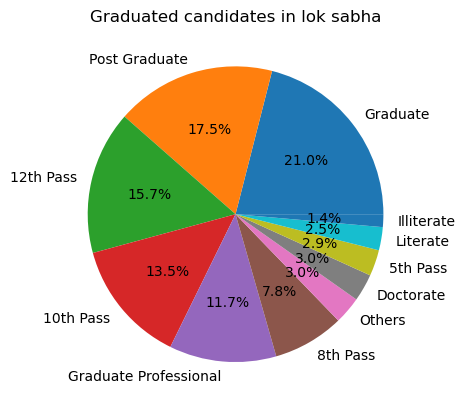

In [9]:
# pie chart showing the distribution of political parties in the Lok Sabha:

# Count the number of MPs in each party
party_counts = lok_sabha_df['Education'].value_counts()

# Create a pie chart
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%')
plt.title('Graduated candidates in lok sabha')
plt.show()


# Histogram

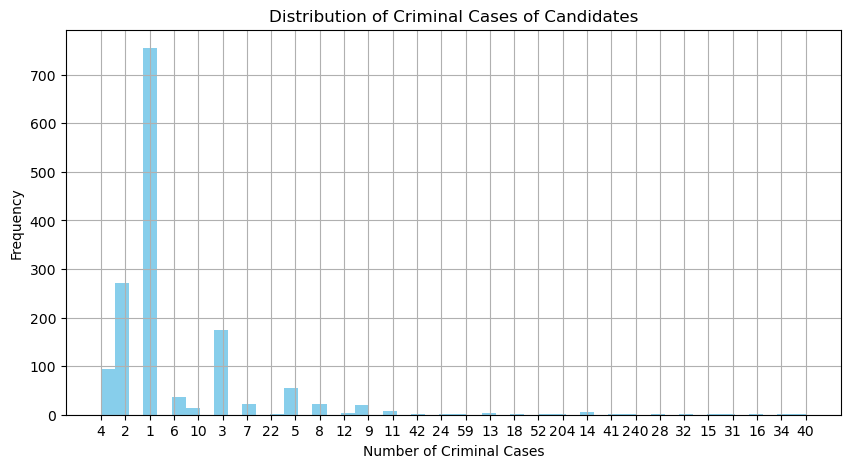

In [10]:
# plotting a histogram to represent the criminal cases by each party
plt.figure(figsize=(10, 5))
lok_sabha_df['Criminal_Cases'].hist(bins=50, color='skyblue')
plt.xlabel('Number of Criminal Cases')
plt.ylabel('Frequency')
plt.title('Distribution of Criminal Cases of Candidates')
plt.show()

# Scatter plot

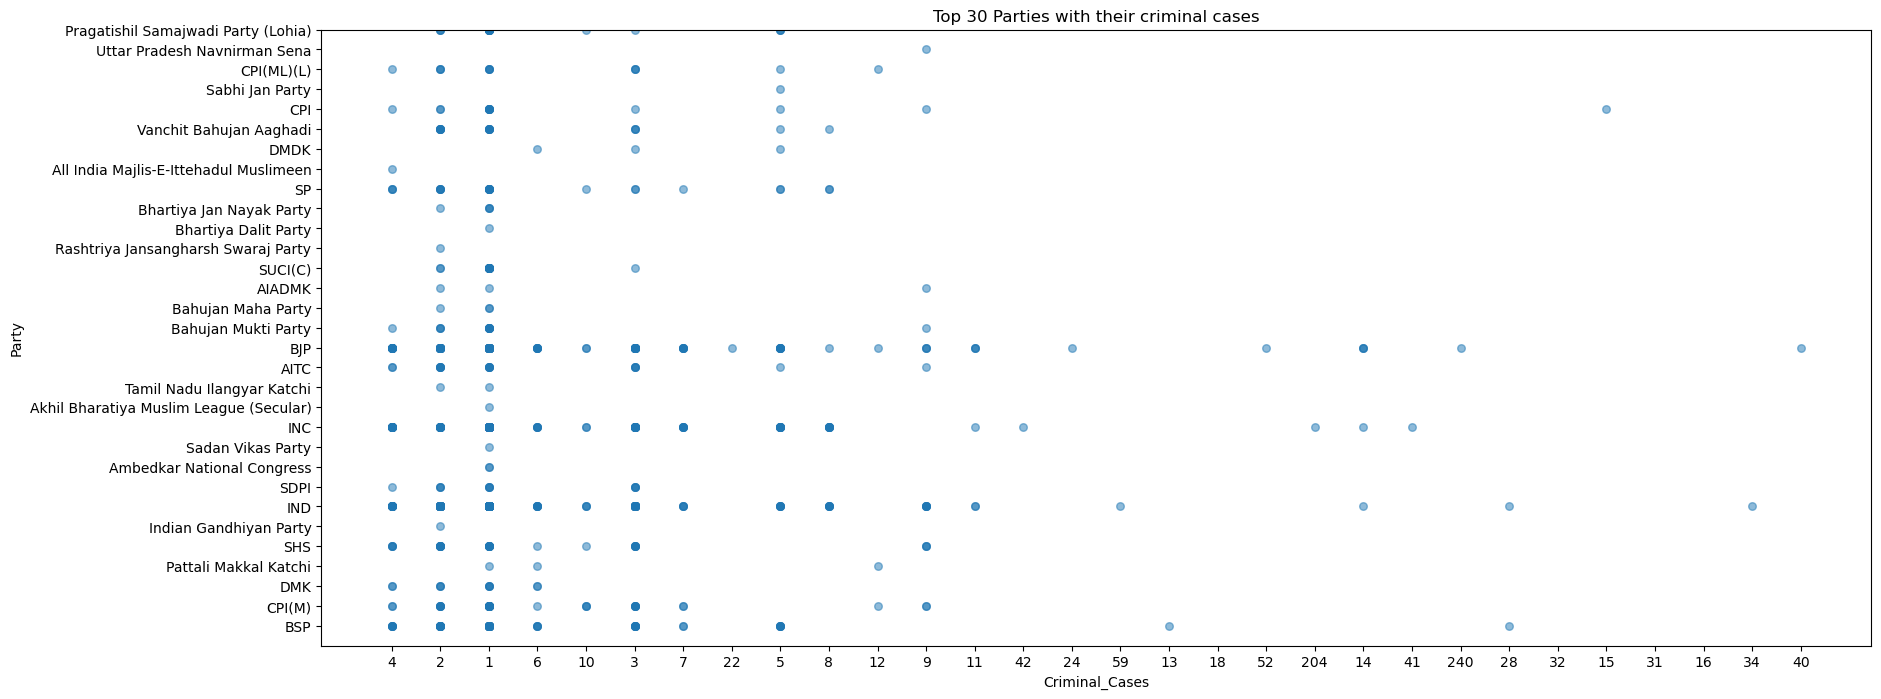

In [11]:
#visualizing  the relationship between the parties with Criminal cases using a scatter plot:

plt.figure(figsize=(20, 8))
plt.scatter(lok_sabha_df['Criminal_Cases'], lok_sabha_df['Party'], s=30, alpha=0.5)
#plt.scatter(lok_sabha_df['Criminal_Cases'], lok_sabha_df['Party'])
plt.xlabel('Criminal_Cases')
plt.ylim(-1,30)
plt.ylabel('Party')
plt.title('Top 30 Parties with their criminal cases')
plt.show()

# Bar Graph

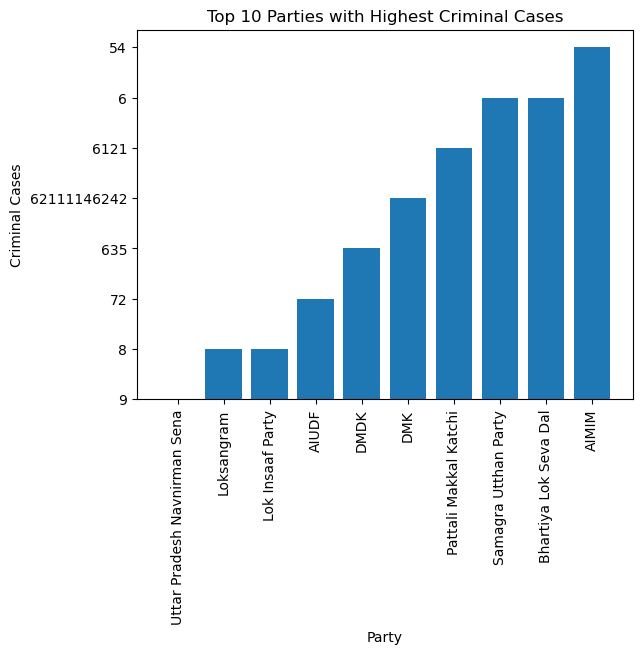

In [12]:
# group by party and sum up criminal cases
cases_grouped = lok_sabha_df.groupby(by="Party")["Criminal_Cases"].sum()

# sort by criminal cases in descending order and select top 10 parties
top_10_parties = cases_grouped.sort_values(ascending=False).head(10)

plt.bar(top_10_parties.index, top_10_parties.values)
plt.xlabel('Party')
plt.ylabel('Criminal Cases')
plt.title('Top 10 Parties with Highest Criminal Cases')
plt.xticks(rotation=90)# rotate x-axis labels for better readability

plt.show()

# LINEAR REGRESSION

In [20]:
# perform a linear regression analysis
from sklearn.linear_model import LinearRegression

X = lok_sabha_df['Total_Assets'].values.reshape(-1,1)
y = lok_sabha_df['Liabilities'].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

# print the slope and intercept of the best-fit line
print('Slope:', reg.coef_[0][0])
print('Intercept:', reg.intercept_[0])

Slope: 0.12424243163010577
Intercept: 2054033.7531445045


# POLYNOMIAL REGRESSION

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
lok_sabha_df = pd.read_sql_query("SELECT * FROM Grad_Lok_Can", conn)

# Extract the independent and dependent variables
X = lok_sabha_df['Total_Assets'].values.reshape(-1, 1)
y = lok_sabha_df['Criminal_Cases'].values.reshape(-1, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create an instance of the decision tree regressor model
model = DecisionTreeRegressor()

# Train the model using the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared:', r2)


Mean squared error: 134.18372751909337
R-squared: -0.2630538993388405


# Text analysis - Frequency Analysis

In [15]:
lok_sabha_df = pd.read_sql_query("SELECT * FROM Grad_Lok_Can", conn)

# Count the frequency of values in two columns
col1_counts = lok_sabha_df['Party'].value_counts()
col2_counts = lok_sabha_df['Education'].value_counts()

print('Top 20 values and frequency for Party:')
print(col1_counts[:20])
print('\nTop 20 values and frequency for Education:')
print(col2_counts[:20])

Top 20 values and frequency for Party:
IND                                    399
BJP                                    175
INC                                    165
BSP                                     85
CPI(M)                                  40
SHS                                     34
SP                                      26
AITC                                    20
SUCI(C)                                 20
Vanchit Bahujan Aaghadi                 19
RJD                                     18
Pragatishil Samajwadi Party (Lohia)     18
NCP                                     17
CPI                                     15
JD(U)                                   14
Bahujan Mukti Party                     14
YSRCP                                   13
CPI(ML)(L)                              13
SDPI                                    12
DMK                                     11
Name: Party, dtype: int64

Top 20 values and frequency for Education:
Graduate                 316
Po